# DataPrep 

### Import library

In [2]:
import requests
import pandas as pd
import json
import numpy as np

### Read the JSON data fetched from the web & pandas transform it to Dataframe

In [3]:
req = requests.get("https://api.covid19api.com/live/country/united-states").json()
covid=pd.DataFrame(req)

In [4]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5893 entries, 0 to 5892
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           5893 non-null   object
 1   Country      5893 non-null   object
 2   CountryCode  5893 non-null   object
 3   Province     5893 non-null   object
 4   City         5893 non-null   object
 5   CityCode     5893 non-null   object
 6   Lat          5893 non-null   object
 7   Lon          5893 non-null   object
 8   Confirmed    5893 non-null   int64 
 9   Deaths       5893 non-null   int64 
 10  Recovered    5893 non-null   int64 
 11  Active       5893 non-null   int64 
 12  Date         5893 non-null   object
dtypes: int64(4), object(9)
memory usage: 598.6+ KB


In [5]:
covid.describe()

,Confirmed,Deaths,Recovered,Active
count,5.893000e+03,5893.000000,5893.0,5.893000e+03
mean,6.852553e+05,11568.342440,0.0,6.736869e+05
std,8.349321e+05,14443.925806,0.0,8.209351e+05
min,0.000000e+00,0.000000,0.0,0.000000e+00
25%,1.400210e+05,2075.000000,0.0,1.376790e+05
50%,4.614250e+05,7265.000000,0.0,4.532760e+05
75%,8.355200e+05,13938.000000,0.0,8.245170e+05
max,4.773284e+06,69990.000000,0.0,4.703294e+06


# Graphing

### Import  new graphing library called Seaborn

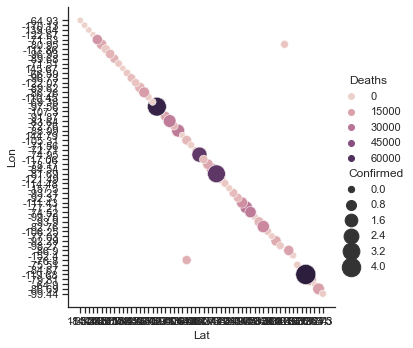

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.relplot(data=covid,x="Lat",y="Lon",hue="Deaths",size="Confirmed",sizes=(40,400))

### Failed! To check why -- Inspect  data type

In [7]:
covid['Lat'][0]

'18.35'

In [8]:
covid['Lon'][0]

'-64.93'

### It is a string 

### convert it to a floating number

In [9]:
covid['Lat']=covid['Lat'].astype('float16')
covid['Lon']=covid['Lon'].astype('float16')

In [10]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5893 entries, 0 to 5892
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           5893 non-null   object 
 1   Country      5893 non-null   object 
 2   CountryCode  5893 non-null   object 
 3   Province     5893 non-null   object 
 4   City         5893 non-null   object 
 5   CityCode     5893 non-null   object 
 6   Lat          5893 non-null   float16
 7   Lon          5893 non-null   float16
 8   Confirmed    5893 non-null   int64  
 9   Deaths       5893 non-null   int64  
 10  Recovered    5893 non-null   int64  
 11  Active       5893 non-null   int64  
 12  Date         5893 non-null   object 
dtypes: float16(2), int64(4), object(7)
memory usage: 529.6+ KB


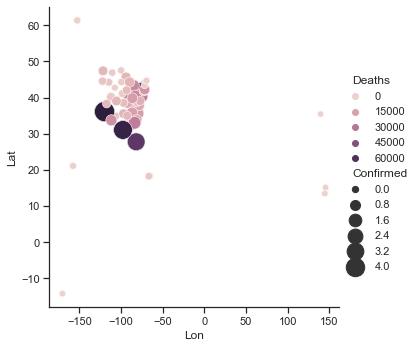

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.relplot(data=covid,x="Lon",y="Lat",hue="Deaths",size="Confirmed",sizes=(40,400))

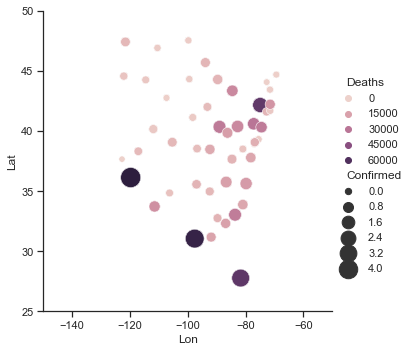

In [12]:
fig=sns.relplot(data=covid, x="Lon",y="Lat", hue="Deaths",size="Confirmed",sizes=(40,400)).set(ylim=(25,50),xlim=(-150,-50))

# Dataset COVID

Our goal is to correlate beds per 10,000 populations to mortality for COVID. Lets bring in another data set that tells us about the number of beds per sample. This table has one-line per hospital. We will need to aggregate or sum by county in order to get the total number of beds per county. First the API

### Loading from API

In [13]:
req=requests.get("https://www.communitybenefitinsight.org/api/get_hospitals.php").json()
hospitals=pd.DataFrame(req)
hospitals.head()

,hospital_id,hospital_org_id,ein,name,name2,name3,street_address,city,state,zip_code,...,fips_state_and_county_code,hospital_bed_count,chrch_affl_f,urban_location_f,children_hospital_f,memb_counc_teach_hosps_f,medicare_provider_number,county,hospital_bed_size,updated_dt
0,1,1,630307951,Mizell Memorial Hospital,,Mizell Memorial Hospital,702 Main Street,Opp,AL,36462,...,01039,99,N,N,N,N,010007,Covington County,<100 beds,"October 1, 2021"
1,2,2,630578923,St Vincents East,,St Vincents East,50 Medical Park Drive East,Birmingham,AL,35235,...,01073,362,N,Y,N,Y,010011,Jefferson County,>299 beds,"October 1, 2021"
2,3,3,630312913,Shelby Baptist Medical Center,,Shelby Baptist Medical Center,1000 First Street North,Alabaster,AL,35007,...,01117,252,N,Y,N,N,010016,Shelby County,100-299 beds,"October 1, 2021"
3,4,4,630459034,Callahan Eye Foundation Hosp,,Callahan Eye Foundation Hosp,1720 University Boulevard,Birmingham,AL,35233,...,01073,106,N,Y,N,Y,010018,Jefferson County,100-299 beds,"October 1, 2021"
4,5,5,581973570,Cherokee Medical Center,,Cherokee Medical Center,100 Northwood Drive,Centre,AL,35960,...,01019,60,N,N,N,N,010022,Cherokee County,<100 beds,"October 1, 2021"


### CREATE HospitalInfoPerCounty Table

 Sum `hospital_bed_count` in each `county`
 Because `county` is not unique in the US
 so **create a new column called** `state_county`

In [14]:
req=requests.get("https://www.communitybenefitinsight.org/api/get_hospitals.php").json()
hospitals=pd.DataFrame(req)
hospitals['state_county']=hospitals['state']+'_'+hospitals['county']
hospitals.head()

,hospital_id,hospital_org_id,ein,name,name2,name3,street_address,city,state,zip_code,...,hospital_bed_count,chrch_affl_f,urban_location_f,children_hospital_f,memb_counc_teach_hosps_f,medicare_provider_number,county,hospital_bed_size,updated_dt,state_county
0,1,1,630307951,Mizell Memorial Hospital,,Mizell Memorial Hospital,702 Main Street,Opp,AL,36462,...,99,N,N,N,N,010007,Covington County,<100 beds,"October 1, 2021",AL_Covington County
1,2,2,630578923,St Vincents East,,St Vincents East,50 Medical Park Drive East,Birmingham,AL,35235,...,362,N,Y,N,Y,010011,Jefferson County,>299 beds,"October 1, 2021",AL_Jefferson County
2,3,3,630312913,Shelby Baptist Medical Center,,Shelby Baptist Medical Center,1000 First Street North,Alabaster,AL,35007,...,252,N,Y,N,N,010016,Shelby County,100-299 beds,"October 1, 2021",AL_Shelby County
3,4,4,630459034,Callahan Eye Foundation Hosp,,Callahan Eye Foundation Hosp,1720 University Boulevard,Birmingham,AL,35233,...,106,N,Y,N,Y,010018,Jefferson County,100-299 beds,"October 1, 2021",AL_Jefferson County
4,5,5,581973570,Cherokee Medical Center,,Cherokee Medical Center,100 Northwood Drive,Centre,AL,35960,...,60,N,N,N,N,010022,Cherokee County,<100 beds,"October 1, 2021",AL_Cherokee County


as_index : bool, default True
For aggregated output, return object with group labels as the index. Only relevant for DataFrame input. as_index=False is effectively “SQL-style” grouped output.
agg is an alias for aggregate

In [15]:
HospitalInfoPerCounty=hospitals.groupby(['state_county'], as_index=False)['hospital_bed_count'].agg('sum')
HospitalInfoPerCounty.head()

,state_county,hospital_bed_count
0,AK_Anchorage Municipality,401
1,AK_Fairbanks North Star Borough,162
2,AK_Kenai Peninsula Borough,49622
3,AK_Ketchikan Gateway Borough,25
4,AK_Kodiak Island Borough,25


# It is NOT right

Ok – there clearly aren’t 49622 in AK_Kenai Peninsula Borough. Lets inspect further. And we’ll have to address it, but the county have  County in the end. Lets fix one thing at a time. First, lets see the types.

### Turning a string into a number in `hospitals.hospital_bed_count`

In [16]:
hospitals.hospital_bed_count[0]

'99'

In [17]:
hospitals.hospital_bed_count=hospitals.hospital_bed_count.astype('float16')


In [18]:
hospitals.hospital_bed_count[0]

99.0

In [20]:
hospitals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3380 entries, 0 to 3379
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hospital_id                 3380 non-null   object 
 1   hospital_org_id             3380 non-null   object 
 2   ein                         3380 non-null   object 
 3   name                        3380 non-null   object 
 4   name2                       3380 non-null   object 
 5   name3                       3380 non-null   object 
 6   street_address              3380 non-null   object 
 7   city                        3380 non-null   object 
 8   state                       3380 non-null   object 
 9   zip_code                    3380 non-null   object 
 10  american_association_id     3380 non-null   object 
 11  fips_state_and_county_code  3380 non-null   object 
 12  hospital_bed_count          3380 non-null   float16
 13  chrch_affl_f                3380 

### CREATE `HospitalInfoPerCounty` and summing for `hospital_bed_count`

We need to create a dataframe that is unique by state_county, and we need to sum across entries on hospital_bed_count.  This is because the state and county may not be unique (e.g. multiple entries for different days).  Its always important to know what tables are unique for a table

In [21]:
HospitalInfoPerCounty=hospitals.groupby(['state_county'], as_index=False)['hospital_bed_count'].agg('sum')
HospitalInfoPerCounty.head()

,state_county,hospital_bed_count
0,AK_Anchorage Municipality,401.0
1,AK_Fairbanks North Star Borough,162.0
2,AK_Kenai Peninsula Borough,77.0
3,AK_Ketchikan Gateway Borough,25.0
4,AK_Kodiak Island Borough,25.0


## Problem

In [49]:
hospital_bed_count = hospitals.hospital_bed_count.astype('float16')

### Substitution and curating

Sometimes data is not fully structured, as is case here.. This is really sub-optimal, but there are times when you want an approximate solution to understand the scope of the problem. In this case, lets just focus on those that end in County and remove that text, noting we won’t get all matches, but we should get a majority.

In [22]:
HospitalInfoPerCounty['state_county']=HospitalInfoPerCounty['state_county'].str.replace(' County','')
HospitalInfoPerCounty.head(5)

,state_county,hospital_bed_count
0,AK_Anchorage Municipality,401.0
1,AK_Fairbanks North Star Borough,162.0
2,AK_Kenai Peninsula Borough,77.0
3,AK_Ketchikan Gateway Borough,25.0
4,AK_Kodiak Island Borough,25.0


## Create `CovidPerCounty` DataFrame

In [23]:
import requests
import pandas as pd
import json
import numpy as np
req=requests.get("https://webhooks.mongodb-stitch.com/api/client/v2.0/app/covid-19-qppza/service/REST-API/incoming_webhook/us_only?min_date=2021-01-15T00:00:00.000Z&max_date=2021-01-15T00:00:00.000Z").json()
covid=pd.DataFrame(req)

In [24]:
covid.head(5)

,_id,uid,country_iso2,country_iso3,country_code,fips,county,state,country,combined_name,population,loc,date,confirmed,deaths,confirmed_daily,deaths_daily
0,61625f2601a1c2eeb7596fc0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,"Autauga, Alabama, US",55869.0,"{'type': 'Point', 'coordinates': [-86.6441, 32...",2021-01-15T00:00:00.000Z,5103,55,28,0
1,61625f2601a1c2eeb7597232,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,"Baldwin, Alabama, US",223234.0,"{'type': 'Point', 'coordinates': [-87.7221, 30...",2021-01-15T00:00:00.000Z,16002,179,161,2
2,61625f2601a1c2eeb75974a4,84001005,US,USA,840,1005.0,Barbour,Alabama,US,"Barbour, Alabama, US",24686.0,"{'type': 'Point', 'coordinates': [-85.3871, 31...",2021-01-15T00:00:00.000Z,1712,36,16,0
3,61625f2601a1c2eeb7597716,84001007,US,USA,840,1007.0,Bibb,Alabama,US,"Bibb, Alabama, US",22394.0,"{'type': 'Point', 'coordinates': [-87.1251, 32...",2021-01-15T00:00:00.000Z,2130,47,17,0
4,61625f2601a1c2eeb7597988,84001009,US,USA,840,1009.0,Blount,Alabama,US,"Blount, Alabama, US",57826.0,"{'type': 'Point', 'coordinates': [-86.5679, 33...",2021-01-15T00:00:00.000Z,5264,83,45,3


### Convert states to a 2-letter code using a dictionary

In [25]:
us_state_to_abbrev = {
"Alabama": "AL","Alaska": "AK","Arizona": "AZ","Arkansas": "AR", "California": "CA",
"Colorado": "CO","Connecticut": "CT","Delaware": "DE","Florida": "FL","Georgia": "GA",
"Hawaii": "HI","Idaho": "ID","Illinois": "IL","Indiana": "IN","Iowa": "IA","Kansas": "KS",
"Kentucky": "KY","Louisiana": "LA","Maine": "ME","Maryland": "MD","Massachusetts": "MA",
"Michigan": "MI","Minnesota": "MN","Mississippi": "MS","Missouri": "MO","Montana": "MT",
"Nebraska": "NE","Nevada": "NV","New Hampshire": "NH","New Jersey": "NJ","New Mexico": "NM",
"New York": "NY","North Carolina": "NC","North Dakota": "ND","Ohio": "OH",
"Oklahoma": "OK","Oregon": "OR","Pennsylvania": "PA","Rhode Island": "RI",
"South Carolina": "SC","South Dakota": "SD","Tennessee": "TN","Texas": "TX",
"Utah": "UT","Vermont": "VT","Virginia": "VA","Washington": "WA",
"West Virginia": "WV","Wisconsin": "WI","Wyoming": "WY",
"District of Columbia": "DC","American Samoa": "AS","Guam": "GU", "Northern Mariana Islands": "MP",
"Puerto Rico": "PR","United States Minor Outlying Islands": "UM","U.S. Virgin Islands": "VI",
}
covid['state'].replace(us_state_to_abbrev, inplace=True)
covid.head(5)

,_id,uid,country_iso2,country_iso3,country_code,fips,county,state,country,combined_name,population,loc,date,confirmed,deaths,confirmed_daily,deaths_daily
0,61625f2601a1c2eeb7596fc0,84001001,US,USA,840,1001.0,Autauga,AL,US,"Autauga, Alabama, US",55869.0,"{'type': 'Point', 'coordinates': [-86.6441, 32...",2021-01-15T00:00:00.000Z,5103,55,28,0
1,61625f2601a1c2eeb7597232,84001003,US,USA,840,1003.0,Baldwin,AL,US,"Baldwin, Alabama, US",223234.0,"{'type': 'Point', 'coordinates': [-87.7221, 30...",2021-01-15T00:00:00.000Z,16002,179,161,2
2,61625f2601a1c2eeb75974a4,84001005,US,USA,840,1005.0,Barbour,AL,US,"Barbour, Alabama, US",24686.0,"{'type': 'Point', 'coordinates': [-85.3871, 31...",2021-01-15T00:00:00.000Z,1712,36,16,0
3,61625f2601a1c2eeb7597716,84001007,US,USA,840,1007.0,Bibb,AL,US,"Bibb, Alabama, US",22394.0,"{'type': 'Point', 'coordinates': [-87.1251, 32...",2021-01-15T00:00:00.000Z,2130,47,17,0
4,61625f2601a1c2eeb7597988,84001009,US,USA,840,1009.0,Blount,AL,US,"Blount, Alabama, US",57826.0,"{'type': 'Point', 'coordinates': [-86.5679, 33...",2021-01-15T00:00:00.000Z,5264,83,45,3


When inplace=True is passed, the data is renamed in place (it returns nothing), so you'd use:

df.an_operation(inplace=True)
When inplace=False is passed (this is the default value, so isn't necessary), performs the operation and returns a copy of the object, so you'd use:

In [26]:
covid.head(5)

,_id,uid,country_iso2,country_iso3,country_code,fips,county,state,country,combined_name,population,loc,date,confirmed,deaths,confirmed_daily,deaths_daily
0,61625f2601a1c2eeb7596fc0,84001001,US,USA,840,1001.0,Autauga,AL,US,"Autauga, Alabama, US",55869.0,"{'type': 'Point', 'coordinates': [-86.6441, 32...",2021-01-15T00:00:00.000Z,5103,55,28,0
1,61625f2601a1c2eeb7597232,84001003,US,USA,840,1003.0,Baldwin,AL,US,"Baldwin, Alabama, US",223234.0,"{'type': 'Point', 'coordinates': [-87.7221, 30...",2021-01-15T00:00:00.000Z,16002,179,161,2
2,61625f2601a1c2eeb75974a4,84001005,US,USA,840,1005.0,Barbour,AL,US,"Barbour, Alabama, US",24686.0,"{'type': 'Point', 'coordinates': [-85.3871, 31...",2021-01-15T00:00:00.000Z,1712,36,16,0
3,61625f2601a1c2eeb7597716,84001007,US,USA,840,1007.0,Bibb,AL,US,"Bibb, Alabama, US",22394.0,"{'type': 'Point', 'coordinates': [-87.1251, 32...",2021-01-15T00:00:00.000Z,2130,47,17,0
4,61625f2601a1c2eeb7597988,84001009,US,USA,840,1009.0,Blount,AL,US,"Blount, Alabama, US",57826.0,"{'type': 'Point', 'coordinates': [-86.5679, 33...",2021-01-15T00:00:00.000Z,5264,83,45,3


In [27]:
covid.tail(10)

,_id,uid,country_iso2,country_iso3,country_code,fips,county,state,country,combined_name,population,loc,date,confirmed,deaths,confirmed_daily,deaths_daily
3332,61625f3b01a1c2eeb7794388,84056029,US,USA,840,56029.0,Park,WY,US,"Park, Wyoming, US",29194.0,"{'type': 'Point', 'coordinates': [-109.5853, 4...",2021-01-15T00:00:00.000Z,2396,16,28,0
3333,61625f3b01a1c2eeb77945fa,84056031,US,USA,840,56031.0,Platte,WY,US,"Platte, Wyoming, US",8393.0,"{'type': 'Point', 'coordinates': [-104.9663, 4...",2021-01-15T00:00:00.000Z,515,9,6,0
3334,61625f3b01a1c2eeb779486c,84056033,US,USA,840,56033.0,Sheridan,WY,US,"Sheridan, Wyoming, US",30485.0,"{'type': 'Point', 'coordinates': [-106.8862, 4...",2021-01-15T00:00:00.000Z,2746,17,6,0
3335,61625f3b01a1c2eeb7794ade,84056035,US,USA,840,56035.0,Sublette,WY,US,"Sublette, Wyoming, US",9831.0,"{'type': 'Point', 'coordinates': [-109.9131, 4...",2021-01-15T00:00:00.000Z,633,7,1,0
3336,61625f3b01a1c2eeb7794d50,84056037,US,USA,840,56037.0,Sweetwater,WY,US,"Sweetwater, Wyoming, US",42343.0,"{'type': 'Point', 'coordinates': [-108.8828, 4...",2021-01-15T00:00:00.000Z,3262,26,12,0
3337,61625f3b01a1c2eeb7794fc2,84056039,US,USA,840,56039.0,Teton,WY,US,"Teton, Wyoming, US",23464.0,"{'type': 'Point', 'coordinates': [-110.5891, 4...",2021-01-15T00:00:00.000Z,2605,4,26,0
3338,61625f3b01a1c2eeb7795234,84056041,US,USA,840,56041.0,Uinta,WY,US,"Uinta, Wyoming, US",20226.0,"{'type': 'Point', 'coordinates': [-110.5476, 4...",2021-01-15T00:00:00.000Z,1806,9,12,0
3339,61625f3b01a1c2eeb77954a6,84090056,US,USA,840,90056.0,Unassigned,WY,US,"Unassigned, Wyoming, US",NaN,NaN,2021-01-15T00:00:00.000Z,0,0,0,0
3340,61625f3b01a1c2eeb7795718,84056043,US,USA,840,56043.0,Washakie,WY,US,"Washakie, Wyoming, US",7805.0,"{'type': 'Point', 'coordinates': [-107.6802, 4...",2021-01-15T00:00:00.000Z,840,23,3,0
3341,61625f3b01a1c2eeb779598a,84056045,US,USA,840,56045.0,Weston,WY,US,"Weston, Wyoming, US",6927.0,"{'type': 'Point', 'coordinates': [-104.5675, 4...",2021-01-15T00:00:00.000Z,602,4,0,0


### Create a key to join our tables

The dataframe covid may not be fully unique per state or county. Lets create a new column that we can merge on which concatenates both.

In [28]:
covid['state_county']=covid['state']+'_'+covid['county']
covid.head()

,_id,uid,country_iso2,country_iso3,country_code,fips,county,state,country,combined_name,population,loc,date,confirmed,deaths,confirmed_daily,deaths_daily,state_county
0,61625f2601a1c2eeb7596fc0,84001001,US,USA,840,1001.0,Autauga,AL,US,"Autauga, Alabama, US",55869.0,"{'type': 'Point', 'coordinates': [-86.6441, 32...",2021-01-15T00:00:00.000Z,5103,55,28,0,AL_Autauga
1,61625f2601a1c2eeb7597232,84001003,US,USA,840,1003.0,Baldwin,AL,US,"Baldwin, Alabama, US",223234.0,"{'type': 'Point', 'coordinates': [-87.7221, 30...",2021-01-15T00:00:00.000Z,16002,179,161,2,AL_Baldwin
2,61625f2601a1c2eeb75974a4,84001005,US,USA,840,1005.0,Barbour,AL,US,"Barbour, Alabama, US",24686.0,"{'type': 'Point', 'coordinates': [-85.3871, 31...",2021-01-15T00:00:00.000Z,1712,36,16,0,AL_Barbour
3,61625f2601a1c2eeb7597716,84001007,US,USA,840,1007.0,Bibb,AL,US,"Bibb, Alabama, US",22394.0,"{'type': 'Point', 'coordinates': [-87.1251, 32...",2021-01-15T00:00:00.000Z,2130,47,17,0,AL_Bibb
4,61625f2601a1c2eeb7597988,84001009,US,USA,840,1009.0,Blount,AL,US,"Blount, Alabama, US",57826.0,"{'type': 'Point', 'coordinates': [-86.5679, 33...",2021-01-15T00:00:00.000Z,5264,83,45,3,AL_Blount


## Create a dataframe with unique CovidPerCount

We will group and sum for deaths, population, and confirmed

In [29]:
CovidPerCounty=covid.groupby(['state_county'], as_index=False).agg({'deaths':'sum','confirmed':'sum','population':'sum','confirmed_daily':'mean','deaths_daily':'mean'})
CovidPerCounty.head(15)

,state_county,deaths,confirmed,population,confirmed_daily,deaths_daily
0,AK_Aleutians East,0,40,3337.0,1,0
1,AK_Aleutians West,0,242,5634.0,3,0
2,AK_Anchorage,129,24530,288000.0,92,0
3,AK_Bethel,12,2911,18386.0,26,0
4,AK_Bristol Bay,0,0,836.0,0,0
5,AK_Bristol Bay plus Lake and Peninsula,0,163,2428.0,1,0
6,AK_Chugach,3,241,6751.0,0,0
7,AK_Copper River,0,175,2699.0,1,0
8,AK_Denali,0,63,2097.0,0,0
9,AK_Dillingham,1,150,4916.0,1,0


Pandas dataframe.groupby() function is used to split the data into groups based on some criteria. pandas objects can be split on any of their axes. The abstract definition of grouping is to provide a mapping of labels to group names.

## Create mortality within CovidPerCounty

In [30]:
CovidPerCounty['mortality']=CovidPerCounty['deaths']/CovidPerCounty['confirmed']
CovidPerCounty.head(5)

,state_county,deaths,confirmed,population,confirmed_daily,deaths_daily,mortality
0,AK_Aleutians East,0,40,3337.0,1,0,0.000000
1,AK_Aleutians West,0,242,5634.0,3,0,0.000000
2,AK_Anchorage,129,24530,288000.0,92,0,0.005259
3,AK_Bethel,12,2911,18386.0,26,0,0.004122
4,AK_Bristol Bay,0,0,836.0,0,0,NaN


## Join HospitalInfoPerCounty and CovidPerCounty by state_county

In [31]:
Hospital_Covid_PerCounty=pd.merge(HospitalInfoPerCounty,CovidPerCounty,on='state_county')
Hospital_Covid_PerCounty=Hospital_Covid_PerCounty[Hospital_Covid_PerCounty['population']>50000]
Hospital_Covid_PerCounty=Hospital_Covid_PerCounty[Hospital_Covid_PerCounty['population']<300000]
Hospital_Covid_PerCounty=Hospital_Covid_PerCounty[Hospital_Covid_PerCounty['confirmed']>10]
Hospital_Covid_PerCounty.head()

,state_county,hospital_bed_count,deaths,confirmed,population,confirmed_daily,deaths_daily,mortality
0,AL_Baldwin,232.0,179,16002,223234.0,161,2,0.011186
1,AL_Blount,65.0,83,5264,57826.0,45,3,0.015767
2,AL_Calhoun,552.0,200,10982,113605.0,119,3,0.018212
8,AL_Cullman,115.0,104,7960,83768.0,38,10,0.013065
9,AL_Elmore,69.0,101,7723,81209.0,53,0,0.013078


In [32]:
[i for i in Hospital_Covid_PerCounty]

['state_county',
 'hospital_bed_count',
 'deaths',
 'confirmed',
 'population',
 'confirmed_daily',
 'deaths_daily',
 'mortality']

In [80]:
Hospital_Covid_PerCounty['hospital_bed_count']

0       232.0
1        65.0
2       552.0
8       115.0
9        69.0
        ...  
1636    720.0
1641     70.0
1642    173.0
1649    343.0
1653    217.0
Name: hospital_bed_count, Length: 560, dtype: float16

In [33]:
bed_per_people=Hospital_Covid_PerCounty['hospital_bed_count']/Hospital_Covid_PerCounty['population']
print(bed_per_people)

0       0.001039
1       0.001124
2       0.004859
8       0.001373
9       0.000850
          ...   
1636    0.006817
1641    0.001240
1642    0.002358
1649    0.004107
1653    0.002717
Length: 560, dtype: float64


In [34]:
df=Hospital_Covid_PerCounty
df

,state_county,hospital_bed_count,deaths,confirmed,population,confirmed_daily,deaths_daily,mortality
0,AL_Baldwin,232.0,179,16002,223234.0,161,2,0.011186
1,AL_Blount,65.0,83,5264,57826.0,45,3,0.015767
2,AL_Calhoun,552.0,200,10982,113605.0,119,3,0.018212
8,AL_Cullman,115.0,104,7960,83768.0,38,10,0.013065
9,AL_Elmore,69.0,101,7723,81209.0,53,0,0.013078
...,...,...,...,...,...,...,...,...
1636,WV_Monongalia,720.0,52,6311,105612.0,67,1,0.008240
1641,WV_Putnam,70.0,63,3444,56450.0,37,2,0.018293
1642,WV_Raleigh,173.0,37,3505,73361.0,79,1,0.010556
1649,WV_Wood,343.0,76,5993,83518.0,54,6,0.012681


In [35]:
df['bed_per_people']= bed_per_people
df

,state_county,hospital_bed_count,deaths,confirmed,population,confirmed_daily,deaths_daily,mortality,bed_per_people
0,AL_Baldwin,232.0,179,16002,223234.0,161,2,0.011186,0.001039
1,AL_Blount,65.0,83,5264,57826.0,45,3,0.015767,0.001124
2,AL_Calhoun,552.0,200,10982,113605.0,119,3,0.018212,0.004859
8,AL_Cullman,115.0,104,7960,83768.0,38,10,0.013065,0.001373
9,AL_Elmore,69.0,101,7723,81209.0,53,0,0.013078,0.000850
...,...,...,...,...,...,...,...,...,...
1636,WV_Monongalia,720.0,52,6311,105612.0,67,1,0.008240,0.006817
1641,WV_Putnam,70.0,63,3444,56450.0,37,2,0.018293,0.001240
1642,WV_Raleigh,173.0,37,3505,73361.0,79,1,0.010556,0.002358
1649,WV_Wood,343.0,76,5993,83518.0,54,6,0.012681,0.004107


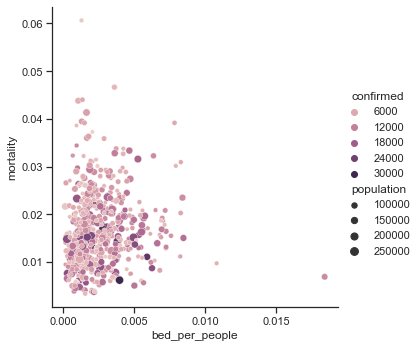

In [36]:
final_plot=sns.relplot(data=Hospital_Covid_PerCounty, x="bed_per_people",y="mortality",hue="confirmed",size="population")

In [37]:
df

,state_county,hospital_bed_count,deaths,confirmed,population,confirmed_daily,deaths_daily,mortality,bed_per_people
0,AL_Baldwin,232.0,179,16002,223234.0,161,2,0.011186,0.001039
1,AL_Blount,65.0,83,5264,57826.0,45,3,0.015767,0.001124
2,AL_Calhoun,552.0,200,10982,113605.0,119,3,0.018212,0.004859
8,AL_Cullman,115.0,104,7960,83768.0,38,10,0.013065,0.001373
9,AL_Elmore,69.0,101,7723,81209.0,53,0,0.013078,0.000850
...,...,...,...,...,...,...,...,...,...
1636,WV_Monongalia,720.0,52,6311,105612.0,67,1,0.008240,0.006817
1641,WV_Putnam,70.0,63,3444,56450.0,37,2,0.018293,0.001240
1642,WV_Raleigh,173.0,37,3505,73361.0,79,1,0.010556,0.002358
1649,WV_Wood,343.0,76,5993,83518.0,54,6,0.012681,0.004107


In [39]:
df['people_per_bed']=df['population']/df['hospital_bed_count']
df

,state_county,hospital_bed_count,deaths,confirmed,population,confirmed_daily,deaths_daily,mortality,bed_per_people,people_per_bed
0,AL_Baldwin,232.0,179,16002,223234.0,161,2,0.011186,0.001039,962.215517
1,AL_Blount,65.0,83,5264,57826.0,45,3,0.015767,0.001124,889.630769
2,AL_Calhoun,552.0,200,10982,113605.0,119,3,0.018212,0.004859,205.806159
8,AL_Cullman,115.0,104,7960,83768.0,38,10,0.013065,0.001373,728.417391
9,AL_Elmore,69.0,101,7723,81209.0,53,0,0.013078,0.000850,1176.942029
...,...,...,...,...,...,...,...,...,...,...
1636,WV_Monongalia,720.0,52,6311,105612.0,67,1,0.008240,0.006817,146.683333
1641,WV_Putnam,70.0,63,3444,56450.0,37,2,0.018293,0.001240,806.428571
1642,WV_Raleigh,173.0,37,3505,73361.0,79,1,0.010556,0.002358,424.052023
1649,WV_Wood,343.0,76,5993,83518.0,54,6,0.012681,0.004107,243.492711


# People per hospital bed vs mortality

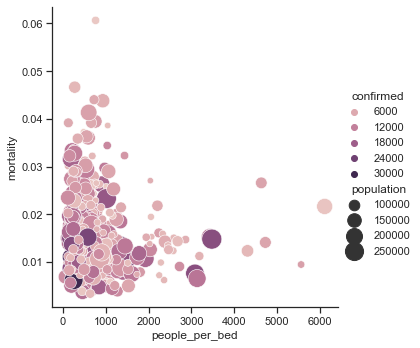

In [40]:
final_plot1=sns.relplot(data=df, x="people_per_bed",y="mortality",hue="confirmed",size="population",sizes=(40, 400))